# Data Mining a Grundlagen Maschinelles Lernen 1 - Semesterprojekt
<b> Wintersemester 2024/2025 <br>

# Imports von Bibliotheken und Daten

### Import der Bibliotheken

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import linear_model
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
import pvlib

### Import der Daten

In [ ]:
df_forecasts = pd.read_pickle('./data/forecasts.pkl')
df_energy_train = pd.read_pickle('./data/energy_train.pkl')
df_energy_test1 = pd.read_pickle('./data/energy_test1.pkl') # Test Set, wo es Feedback gibt
df_energy_test2 = pd.read_pickle('./data/energy_test2.pkl') # Test Set, wo es kein Feedback gibt

# Preprocessing

## Preprocessing forecasts

In [3]:
# Rundung SolarDownwardRadiation
df_forecasts['SolarDownwardRadiation'] = df_forecasts['SolarDownwardRadiation'].round(3)

# Duplicate löschen für forecasts
df_forecasts.drop_duplicates(inplace=True)
# Duplicate löschen für energy_train
df_energy_train.drop_duplicates(inplace=True)

In [4]:
# Anzeigen der NaN
df_forecasts.loc[df_forecasts.isna().any(axis=1)]

,ref_datetime,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model
4770,2020-10-13 06:00:00+00:00,20,NaN,NaN,NaN,DWD ICON
4771,2020-10-13 06:00:00+00:00,21,NaN,NaN,NaN,DWD ICON
4772,2020-10-13 06:00:00+00:00,22,NaN,NaN,NaN,DWD ICON
4773,2020-10-13 06:00:00+00:00,23,NaN,NaN,NaN,DWD ICON
4774,2020-10-13 06:00:00+00:00,24,NaN,NaN,NaN,DWD ICON
...,...,...,...,...,...,...
432716,2022-09-10 00:00:00+00:00,44,0.000,NaN,NaN,NCEP GFS
432723,2022-09-10 00:00:00+00:00,51,0.000,NaN,NaN,NCEP GFS
432727,2022-09-10 00:00:00+00:00,55,125.390,NaN,NaN,NCEP GFS
432729,2022-09-10 00:00:00+00:00,57,334.868,NaN,NaN,NCEP GFS


In [5]:
# Erstelle zwei neue Dataframes auf Grundlage Weather Model Split von DWD und NCEP
df_dwd = df_forecasts[df_forecasts['Weather Model'] == 'DWD ICON'].copy()
df_ncep = df_forecasts[df_forecasts['Weather Model'] == 'NCEP GFS'].copy()

In [6]:
# Spalte Weather Model aus den beiden neuen Dataframes löschen
df_dwd.drop(columns="Weather Model", inplace=True)
df_ncep.drop(columns= "Weather Model", inplace=True)
df_dwd

,ref_datetime,valid_time,SolarDownwardRadiation,CloudCover,Temperature
0,2020-09-20 00:00:00+00:00,20,-0.011,0.366211,13.823755
1,2020-09-20 00:00:00+00:00,21,0.001,0.471512,13.427564
2,2020-09-20 00:00:00+00:00,22,0.002,0.398212,13.093005
3,2020-09-20 00:00:00+00:00,23,-0.002,0.292247,12.667871
4,2020-09-20 00:00:00+00:00,24,-0.008,0.327759,12.216522
...,...,...,...,...,...
584426,2024-11-24 06:00:00+00:00,68,1.820,1.000000,2.050000
584427,2024-11-24 06:00:00+00:00,69,0.930,1.000000,2.700000
584428,2024-11-24 06:00:00+00:00,70,0.050,1.000000,3.130000
584429,2024-11-24 06:00:00+00:00,71,0.000,1.000000,3.560000


<Axes: >

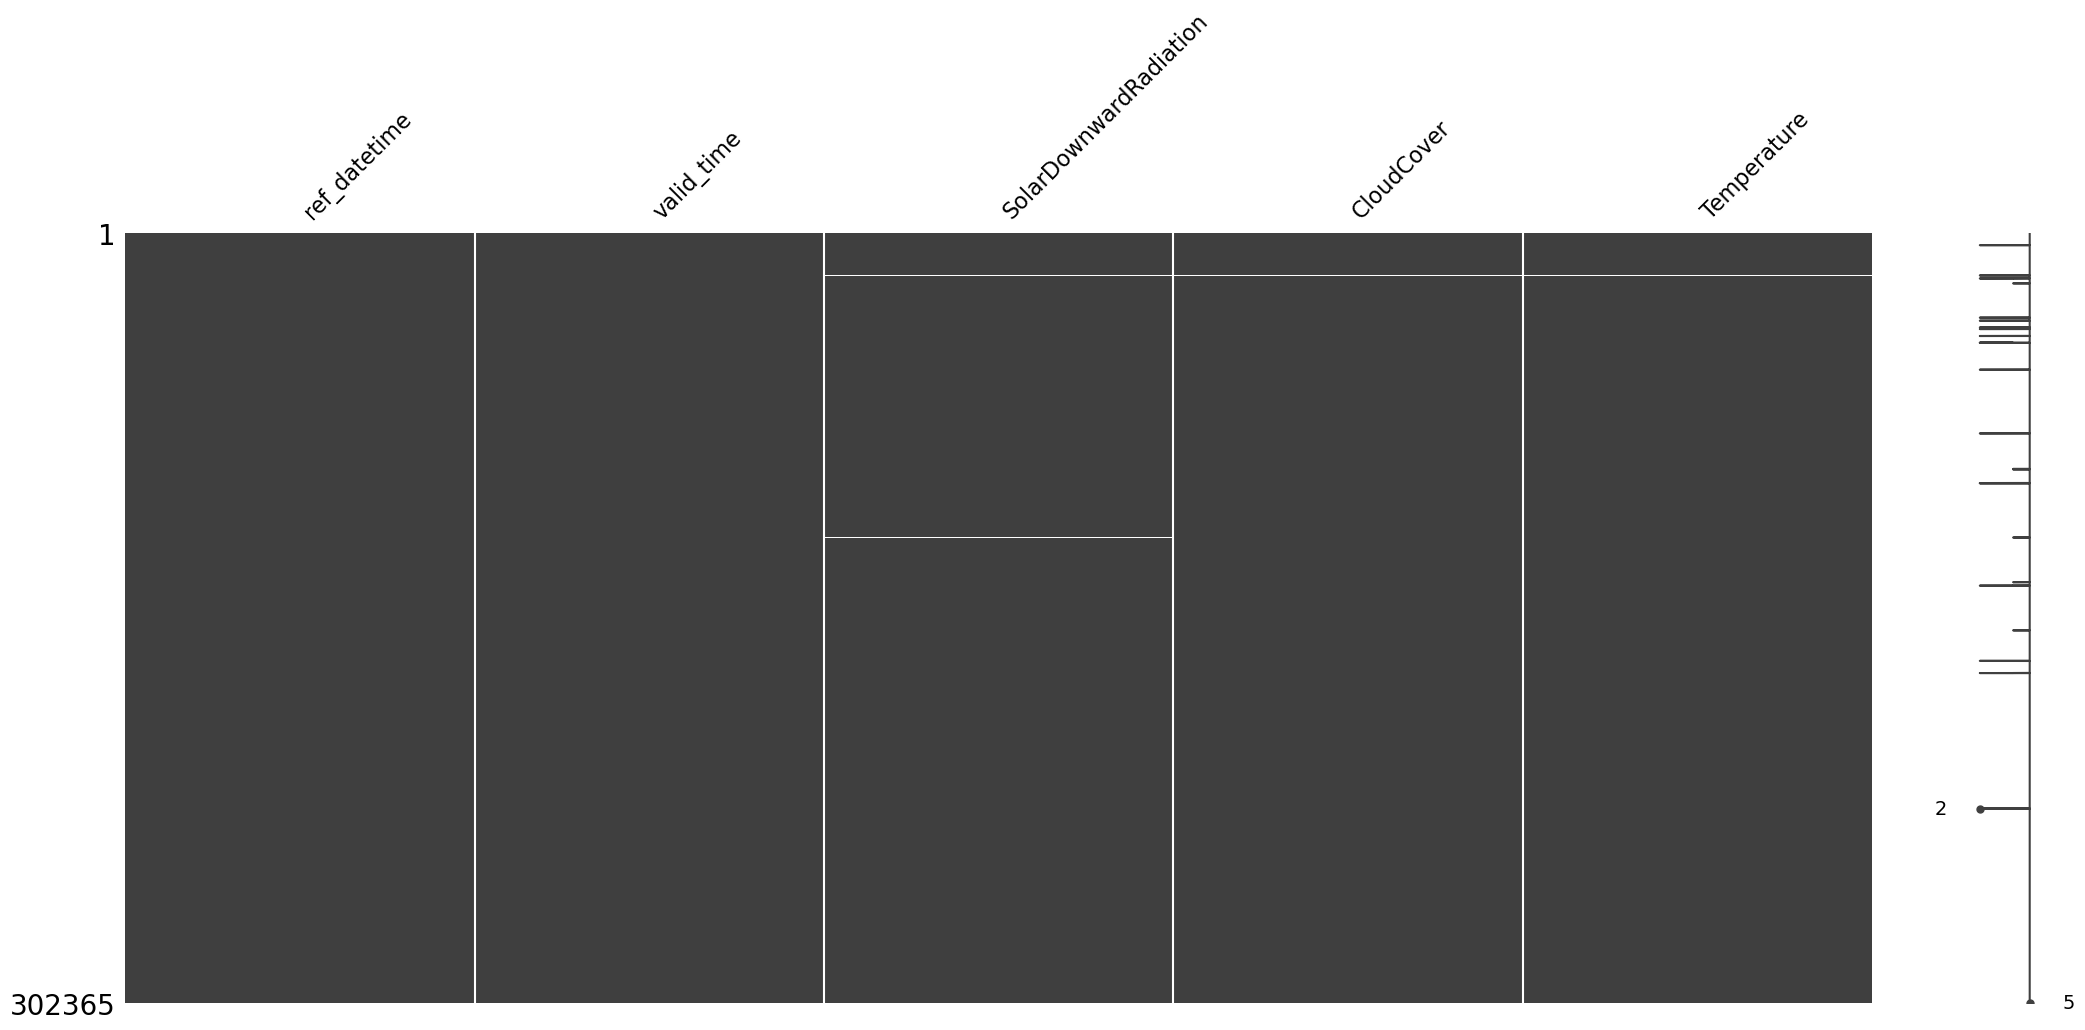

In [7]:
# Visualisierung des Datensatz df_dwd nach fehlenende Werte
msno.matrix(df_dwd) 

<Axes: >

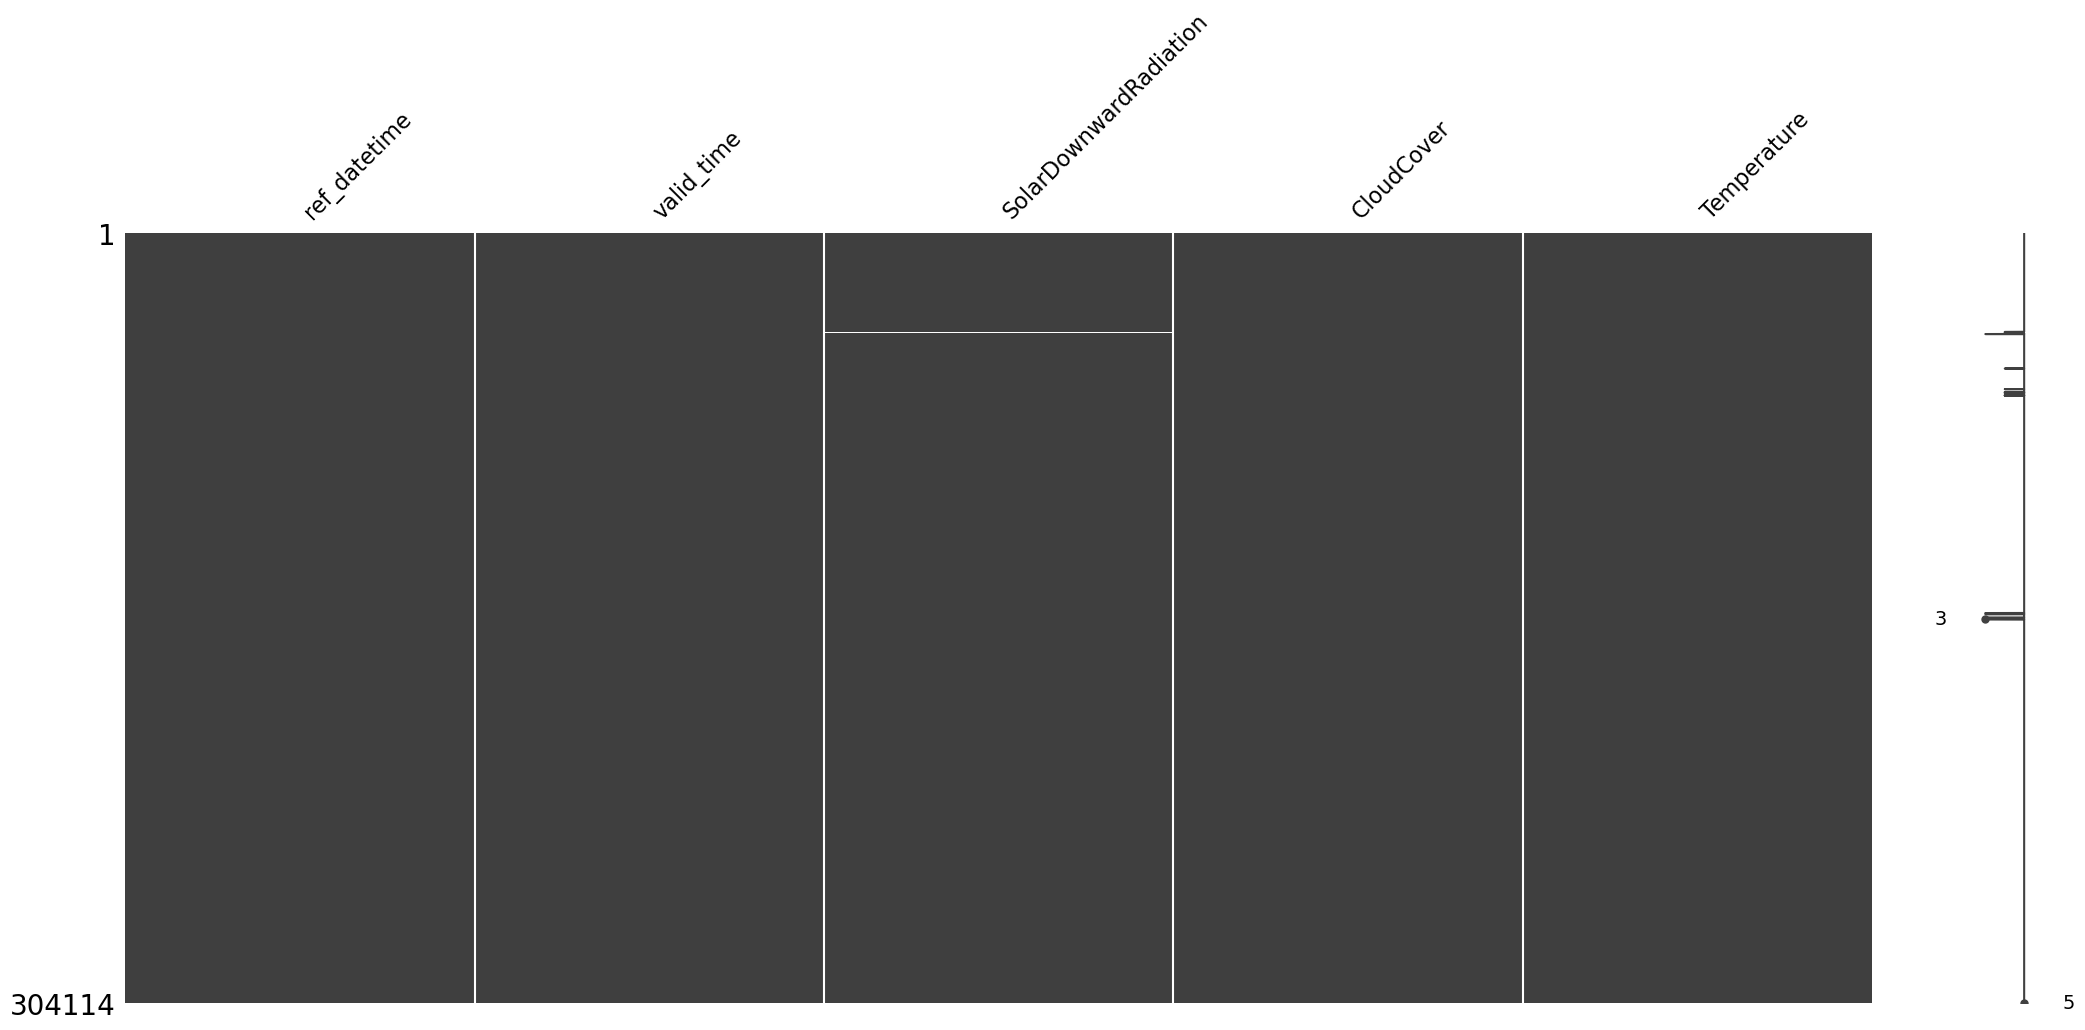

In [8]:
# Visualisierung des Datensatz df_ncep nach fehlenende Werte
msno.matrix(df_ncep)

In [9]:
# Mergen der beiden Dataframen  
df_merge_dwd_ncep = pd.merge(left = df_dwd, right = df_ncep, how = 'outer',on = ["ref_datetime", "valid_time"] , suffixes= ('_DWD', '_NCEP'), validate='one_to_one')

In [10]:
# Anzeigen der NaN
df_merge_dwd_ncep.loc[df_merge_dwd_ncep.isna().any(axis=1)]

,ref_datetime,valid_time,SolarDownwardRadiation_DWD,CloudCover_DWD,Temperature_DWD,SolarDownwardRadiation_NCEP,CloudCover_NCEP,Temperature_NCEP
1431,2020-09-26 18:00:00+00:00,20,NaN,NaN,NaN,60.0,0.9605,13.098437
1432,2020-09-26 18:00:00+00:00,21,NaN,NaN,NaN,49.5,0.8940,12.847318
1433,2020-09-26 18:00:00+00:00,22,NaN,NaN,NaN,18.5,0.9150,12.620010
1434,2020-09-26 18:00:00+00:00,23,NaN,NaN,NaN,2.7,0.9425,12.388659
1435,2020-09-26 18:00:00+00:00,24,NaN,NaN,NaN,0.0,0.9380,12.246722
...,...,...,...,...,...,...,...,...
282803,2024-05-16 00:00:00+00:00,68,0.030,0.564674,14.357782,NaN,NaN,NaN
282804,2024-05-16 00:00:00+00:00,69,0.014,0.629099,13.361511,NaN,NaN,NaN
282805,2024-05-16 00:00:00+00:00,70,0.010,0.639815,12.690979,NaN,NaN,NaN
282806,2024-05-16 00:00:00+00:00,71,0.040,0.689801,12.114581,NaN,NaN,NaN


In [11]:
# NaN füllen, ncep wird mit dwd ersetzt und dwd mit ncep
NA_replacement = {'SolarDownwardRadiation_DWD': df_merge_dwd_ncep['SolarDownwardRadiation_NCEP'],
                  'CloudCover_DWD': df_merge_dwd_ncep['CloudCover_NCEP'],
                  'Temperature_DWD': df_merge_dwd_ncep['Temperature_NCEP'],
                  'SolarDownwardRadiation_NCEP': df_merge_dwd_ncep['SolarDownwardRadiation_DWD'],
                  'CloudCover_NCEP': df_merge_dwd_ncep['CloudCover_DWD'],
                  'Temperature_NCEP': df_merge_dwd_ncep['Temperature_DWD'],
                  }
df_merge_dwd_ncep = df_merge_dwd_ncep.fillna(value=NA_replacement)

In [12]:
# Erstellung einer neuen Spalte "valid_datetime". ref_datetime zeigt wann die Vorhersage erstellt wurde, valid_time zeigt für wann die Vorhersage zählt
df_merge_dwd_ncep["valid_datetime"] = df_merge_dwd_ncep["ref_datetime"]+pd.to_timedelta(unit='hours', arg=df_merge_dwd_ncep["valid_time"])
df_merge_dwd_ncep

,ref_datetime,valid_time,SolarDownwardRadiation_DWD,CloudCover_DWD,Temperature_DWD,SolarDownwardRadiation_NCEP,CloudCover_NCEP,Temperature_NCEP,valid_datetime
0,2020-09-20 00:00:00+00:00,20,-0.011,0.366211,13.823755,0.00,0.0045,13.547716,2020-09-20 20:00:00+00:00
1,2020-09-20 00:00:00+00:00,21,0.001,0.471512,13.427564,0.00,0.0020,13.086699,2020-09-20 21:00:00+00:00
2,2020-09-20 00:00:00+00:00,22,0.002,0.398212,13.093005,0.00,0.0100,12.700010,2020-09-20 22:00:00+00:00
3,2020-09-20 00:00:00+00:00,23,-0.002,0.292247,12.667871,0.00,0.0075,12.443296,2020-09-20 23:00:00+00:00
4,2020-09-20 00:00:00+00:00,24,-0.008,0.327759,12.216522,0.00,0.0020,12.240011,2020-09-21 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...
305805,2024-11-24 06:00:00+00:00,68,1.820,1.000000,2.050000,1.82,1.0000,2.050000,2024-11-27 02:00:00+00:00
305806,2024-11-24 06:00:00+00:00,69,0.930,1.000000,2.700000,0.93,1.0000,2.700000,2024-11-27 03:00:00+00:00
305807,2024-11-24 06:00:00+00:00,70,0.050,1.000000,3.130000,0.05,1.0000,3.130000,2024-11-27 04:00:00+00:00
305808,2024-11-24 06:00:00+00:00,71,0.000,1.000000,3.560000,0.00,1.0000,3.560000,2024-11-27 05:00:00+00:00


In [13]:
# Zeitliche Features 
df_merge_dwd_ncep["dayOfYear"] = df_merge_dwd_ncep["valid_datetime"].dt.dayofyear
df_merge_dwd_ncep["month"] = df_merge_dwd_ncep["valid_datetime"].dt.month
df_merge_dwd_ncep["hour"] = df_merge_dwd_ncep["valid_datetime"].dt.hour

In [14]:
# Es befinden sich negative in der SolarDownwardRadition was unmöglich ist, werden auf 0 gesetzt
df_merge_dwd_ncep["SolarDownwardRadiation_DWD"] = df_merge_dwd_ncep["SolarDownwardRadiation_DWD"].clip(lower = 0 )
df_merge_dwd_ncep["SolarDownwardRadiation_NCEP"] = df_merge_dwd_ncep["SolarDownwardRadiation_NCEP"].clip(lower = 0)

### Sonnenstand

In [15]:
# gefundene Zeitpunkte der Wettervorhersage
df_valid_datetimes = pd.DataFrame(df_merge_dwd_ncep['valid_datetime']).drop_duplicates()

# Standord des Sonnenstandes
location = pvlib.location.Location(52.48, -1.9, tz='Europe/London', name='Birmingham')

#Sonnenstand
df_sun = location.get_solarposition(df_valid_datetimes['valid_datetime']).reset_index()[['valid_datetime', 'apparent_elevation']]

# Sonnenstand an Wettervorhersage anhängen
df_merge_dwd_ncep = pd.merge(left=df_merge_dwd_ncep, right=df_sun)

df_merge_dwd_ncep["apparent_elevation"] = df_merge_dwd_ncep["apparent_elevation"].clip(lower = -8)

In [16]:
df_merge_dwd_ncep

,ref_datetime,valid_time,SolarDownwardRadiation_DWD,CloudCover_DWD,Temperature_DWD,SolarDownwardRadiation_NCEP,CloudCover_NCEP,Temperature_NCEP,valid_datetime,dayOfYear,month,hour,apparent_elevation
0,2020-09-20 00:00:00+00:00,20,0.000,0.366211,13.823755,0.00,0.0045,13.547716,2020-09-20 20:00:00+00:00,264,9,20,-8.0
1,2020-09-20 00:00:00+00:00,21,0.001,0.471512,13.427564,0.00,0.0020,13.086699,2020-09-20 21:00:00+00:00,264,9,21,-8.0
2,2020-09-20 00:00:00+00:00,22,0.002,0.398212,13.093005,0.00,0.0100,12.700010,2020-09-20 22:00:00+00:00,264,9,22,-8.0
3,2020-09-20 00:00:00+00:00,23,0.000,0.292247,12.667871,0.00,0.0075,12.443296,2020-09-20 23:00:00+00:00,264,9,23,-8.0
4,2020-09-20 00:00:00+00:00,24,0.000,0.327759,12.216522,0.00,0.0020,12.240011,2020-09-21 00:00:00+00:00,265,9,0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305805,2024-11-24 06:00:00+00:00,68,1.820,1.000000,2.050000,1.82,1.0000,2.050000,2024-11-27 02:00:00+00:00,332,11,2,-8.0
305806,2024-11-24 06:00:00+00:00,69,0.930,1.000000,2.700000,0.93,1.0000,2.700000,2024-11-27 03:00:00+00:00,332,11,3,-8.0
305807,2024-11-24 06:00:00+00:00,70,0.050,1.000000,3.130000,0.05,1.0000,3.130000,2024-11-27 04:00:00+00:00,332,11,4,-8.0
305808,2024-11-24 06:00:00+00:00,71,0.000,1.000000,3.560000,0.00,1.0000,3.560000,2024-11-27 05:00:00+00:00,332,11,5,-8.0


### Lags (Werte aus der Vergangheit und aus der Zukunft zu einer Wettervorhersage)

In [17]:
# Minus = Zukunft, Plus = Vergangheit
df_merge_dwd_ncep["SolarDownwardRadiation_DWD_lag_-1"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_DWD"].shift(-1)
df_merge_dwd_ncep["SolarDownwardRadiation_DWD_lag_-2"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_DWD"].shift(-2)
df_merge_dwd_ncep["SolarDownwardRadiation_DWD_lag_1"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_DWD"].shift(1)
df_merge_dwd_ncep["SolarDownwardRadiation_DWD_lag_2"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_DWD"].shift(2)
#NCEP
df_merge_dwd_ncep["SolarDownwardRadiation_NCEP_lag_-1"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_NCEP"].shift(-1)
df_merge_dwd_ncep["SolarDownwardRadiation_NCEP_lag_-2"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_NCEP"].shift(-2)
df_merge_dwd_ncep["SolarDownwardRadiation_NCEP_lag_1"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_NCEP"].shift(1)
df_merge_dwd_ncep["SolarDownwardRadiation_NCEP_lag_2"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_NCEP"].shift(2)

#Cloud_Cover
#DWD
df_merge_dwd_ncep["CloudCover_DWD_lag_-1"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_DWD"].shift(-1)
df_merge_dwd_ncep["CloudCover_DWD_lag_-2"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_DWD"].shift(-2)
df_merge_dwd_ncep["CloudCover_DWD_lag_1"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_DWD"].shift(1)
df_merge_dwd_ncep["CloudCover_DWD_lag_2"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_DWD"].shift(2)
#NCEP
df_merge_dwd_ncep["CloudCover_NCEP_lag_-1"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_NCEP"].shift(-1)
df_merge_dwd_ncep["CloudCover_NCEP_lag_-2"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_NCEP"].shift(-2)
df_merge_dwd_ncep["CloudCover_NCEP_lag_1"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_NCEP"].shift(1)
df_merge_dwd_ncep["CloudCover_NCEP_lag_2"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_NCEP"].shift(2)

#Temperature
#DWD
df_merge_dwd_ncep["Temperature_DWD_lag_-1"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_DWD"].shift(-1)
df_merge_dwd_ncep["Temperature_DWD_lag_-2"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_DWD"].shift(-2)
df_merge_dwd_ncep["Temperature_DWD_lag_1"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_DWD"].shift(1)
df_merge_dwd_ncep["Temperature_DWD_lag_2"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_DWD"].shift(2)
#NCEP
df_merge_dwd_ncep["Temperature_NCEP_lag_-1"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_NCEP"].shift(-1)
df_merge_dwd_ncep["Temperature_NCEP_lag_-2"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_NCEP"].shift(-2)
df_merge_dwd_ncep["Temperature_NCEP_lag_1"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_NCEP"].shift(1)
df_merge_dwd_ncep["Temperature_NCEP_lag_2"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_NCEP"].shift(2)

### Differenzen (Der Wert minus der letzte Wert)

In [18]:
#Solar_diff
df_merge_dwd_ncep["SolarDownwardRadiation_DWD_diff"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_DWD"].diff()
df_merge_dwd_ncep["SolarDownwardRadiation_NCEP_diff"] = df_merge_dwd_ncep.groupby("ref_datetime")["SolarDownwardRadiation_NCEP"].diff()
#Cloud_Cover_diff
df_merge_dwd_ncep["CloudCover_DWD_diff"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_DWD"].diff()
df_merge_dwd_ncep["CloudCover_NCEP_diff"] = df_merge_dwd_ncep.groupby("ref_datetime")["CloudCover_NCEP"].diff()
#Temperature
df_merge_dwd_ncep["Temperature_DWD_diff"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_DWD"].diff()
df_merge_dwd_ncep["Temperature_NCEP_diff"] = df_merge_dwd_ncep.groupby("ref_datetime")["Temperature_NCEP"].diff()

## Preprocessing energy_train

### Lücke im energy_train füllen Solar_MWH

In [19]:
df_energy_train.loc[df_energy_train.isna().any(axis=1)]

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh
19255,2022-12-02 07:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659752,NaN
19256,2022-12-02 08:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN
19257,2022-12-02 09:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN
19258,2022-12-02 10:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN


In [20]:
# Der ganze Tag der Lücke anzeigen
df_energy_train.loc[df_energy_train["dtm"].ge("2022-12-02 00:00:00+00:00")&df_energy_train["dtm"].le("2022-12-02 23:00:00+00:00")]

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh
19248,2022-12-02 00:00:00+00:00,2022-12-01 00:00:00+00:00,2205.306806,0.000000
19249,2022-12-02 01:00:00+00:00,2022-12-01 00:00:00+00:00,2205.380477,0.000000
19250,2022-12-02 02:00:00+00:00,2022-12-01 00:00:00+00:00,2205.380477,0.000000
19251,2022-12-02 03:00:00+00:00,2022-12-01 00:00:00+00:00,2205.380477,0.000000
19252,2022-12-02 04:00:00+00:00,2022-12-01 00:00:00+00:00,2205.520120,0.000000
19253,2022-12-02 05:00:00+00:00,2022-12-01 00:00:00+00:00,2205.659763,0.000000
19254,2022-12-02 06:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,0.000000
19255,2022-12-02 07:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659752,NaN
19256,2022-12-02 08:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN
19257,2022-12-02 09:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN


In [21]:
# 2.4 drop Nan von Solar_MWh
df_energy_train = df_energy_train[~df_energy_train[['dtm', 'Solar_MWh']].isnull().any(axis=1)]

### Merge energy_train und forecast

In [23]:
# Merge vom veränderten forecasts und energy_train
df_merge_forecasts_energy_train = pd.merge(left = df_merge_dwd_ncep, right= df_energy_train, left_on = ["ref_datetime", "valid_datetime"], right_on= ["ref_datetime", "dtm"])
df_merge_forecasts_energy_train

,ref_datetime,valid_time,SolarDownwardRadiation_DWD,CloudCover_DWD,Temperature_DWD,SolarDownwardRadiation_NCEP,CloudCover_NCEP,Temperature_NCEP,valid_datetime,dayOfYear,...,Temperature_NCEP_lag_2,SolarDownwardRadiation_DWD_diff,SolarDownwardRadiation_NCEP_diff,CloudCover_DWD_diff,CloudCover_NCEP_diff,Temperature_DWD_diff,Temperature_NCEP_diff,dtm,Solar_capacity_mwp,Solar_MWh
0,2020-09-20 00:00:00+00:00,24,0.000,0.327759,12.216522,0.0,0.002,12.240011,2020-09-21 00:00:00+00:00,265,...,12.700010,0.000,0.0,0.035512,-0.0055,-0.451349,-0.203285,2020-09-21 00:00:00+00:00,2130.510089,0.0
1,2020-09-20 00:00:00+00:00,25,0.009,0.436067,12.015985,0.0,0.003,12.032483,2020-09-21 01:00:00+00:00,265,...,12.443296,0.009,0.0,0.108309,0.0010,-0.200537,-0.207528,2020-09-21 01:00:00+00:00,2130.510089,0.0
2,2020-09-20 00:00:00+00:00,26,0.015,0.468752,11.813635,0.0,0.007,11.833379,2020-09-21 02:00:00+00:00,265,...,12.240011,0.006,0.0,0.032685,0.0040,-0.202351,-0.199104,2020-09-21 02:00:00+00:00,2130.510089,0.0
3,2020-09-20 00:00:00+00:00,27,0.000,0.501229,11.651337,0.0,0.003,11.651335,2020-09-21 03:00:00+00:00,265,...,12.032483,-0.015,0.0,0.032477,-0.0040,-0.162298,-0.182044,2020-09-21 03:00:00+00:00,2130.510089,0.0
4,2020-09-20 00:00:00+00:00,28,0.000,0.514093,11.516748,0.0,0.003,11.484987,2020-09-21 04:00:00+00:00,265,...,11.833379,0.000,0.0,0.012863,0.0000,-0.134588,-0.166348,2020-09-21 04:00:00+00:00,2130.510089,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19963,2022-12-30 18:00:00+00:00,25,0.007,1.000000,12.368402,0.0,1.000,12.096367,2022-12-31 19:00:00+00:00,365,...,11.755176,0.007,0.0,0.000000,0.0000,-0.002551,0.157333,2022-12-31 19:00:00+00:00,2212.678300,0.0
19964,2022-12-30 18:00:00+00:00,26,0.000,0.999310,12.156036,0.0,1.000,12.321498,2022-12-31 20:00:00+00:00,365,...,11.939034,-0.007,0.0,-0.000690,0.0000,-0.212366,0.225131,2022-12-31 20:00:00+00:00,2212.678300,0.0
19965,2022-12-30 18:00:00+00:00,27,0.000,0.997759,11.899714,0.0,1.000,12.386409,2022-12-31 21:00:00+00:00,365,...,12.096367,0.000,0.0,-0.001552,0.0000,-0.256323,0.064911,2022-12-31 21:00:00+00:00,2212.678300,0.0
19966,2022-12-30 18:00:00+00:00,28,0.000,0.999715,11.612177,0.0,1.000,12.532788,2022-12-31 22:00:00+00:00,365,...,12.321498,0.000,0.0,0.001956,0.0000,-0.287537,0.146379,2022-12-31 22:00:00+00:00,2212.678300,0.0


## Train - Test Split

In [24]:
# Trainingset bisschen länger als ein Jahr
X_train = df_merge_forecasts_energy_train.loc[df_merge_forecasts_energy_train["valid_datetime"].lt("2022-01-01 00:00:00+00:00")].copy()
y_train = X_train["Solar_MWh"].copy()

In [25]:
# Testset 1 Jahr lang
X_test = df_merge_forecasts_energy_train.loc[df_merge_forecasts_energy_train["valid_datetime"].ge("2022-01-01 00:00:00+00:00")].copy()
y_test = X_test["Solar_MWh"].copy()

# Modeltraining

## ColumnTransformer

In [26]:
# Eigenen SinCosTransformer basteln, weil Sklearn keinen eigenen bereitstellt
class SinCosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period):
        self.period = period

    def fit(self, X, y=None):
        return self  # Keine Anpassung nötig

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.values  # Falls Pandas Series, in NumPy-Array umwandeln
        sin_values = np.sin(X / self.period * 2 * np.pi)
        cos_values = np.cos(X / self.period * 2 * np.pi)
        return np.column_stack((sin_values, cos_values))

    def get_feature_names_out(self, input_features=None):
        # Erstelle eindeutige Namen für die generierten Sinus- und Cosinus-Features
        if input_features is None:
            input_features = ["feature"]
        return [f"{feature}_sin" for feature in input_features] + [f"{feature}_cos" for feature in input_features]

In [27]:
toDrop = ["ref_datetime", "dtm", "Solar_MWh", "valid_datetime", "hour", "month", "dayOfYear"]
toMinMax = ["SolarDownwardRadiation_NCEP","SolarDownwardRadiation_DWD", 
            "SolarDownwardRadiation_DWD_lag_-1","SolarDownwardRadiation_DWD_lag_-2", "SolarDownwardRadiation_DWD_lag_1","SolarDownwardRadiation_DWD_lag_2",
            "SolarDownwardRadiation_NCEP_lag_-1","SolarDownwardRadiation_NCEP_lag_-2", "SolarDownwardRadiation_NCEP_lag_1","SolarDownwardRadiation_NCEP_lag_2"]
toStandard = ["Temperature_NCEP","Temperature_DWD",
             "Temperature_DWD_lag_-1", "Temperature_DWD_lag_-2", "Temperature_DWD_lag_1", "Temperature_DWD_lag_2",
             "Temperature_NCEP_lag_-1", "Temperature_NCEP_lag_-2", "Temperature_NCEP_lag_1", "Temperature_NCEP_lag_2",
             "SolarDownwardRadiation_DWD_diff", "SolarDownwardRadiation_NCEP_diff", "CloudCover_DWD_diff", "CloudCover_NCEP_diff",
             "Temperature_DWD_diff", "Temperature_NCEP_diff", "apparent_elevation"
             ]

ct = ColumnTransformer(
    transformers=[
        ("Drop", "drop", toDrop),
        ("MinMax", MinMaxScaler(clip=False), toMinMax),
        ("Standard", StandardScaler(), toStandard),
        ("HourSinCos", SinCosTransformer(24), ["hour"]),
        ("MonthSinCos", SinCosTransformer(12), ["month"]),
        ("DayOfYearSinCos", SinCosTransformer(365), ["dayOfYear"]),
    ],
    remainder="passthrough",
    force_int_remainder_cols=False, # Warning von sklearn
)

## Modelle

### Ridge

In [28]:
pl = Pipeline([
    ("ColumnTransformer", ct), 
    ("Ridge", linear_model.Ridge()), 
    ]
)

parameter_ridge = {"Ridge__alpha": [0, 0.1, 1, 10, 100 ,1000]}

grid_search = GridSearchCV(
    estimator = pl, 
    param_grid = parameter_ridge,
    cv = TimeSeriesSplit(n_splits = 14, test_size = 720), # 720 Stunden = 1 Monat
    scoring = "neg_root_mean_squared_error", 
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train) 

Fitting 14 folds for each of 6 candidates, totalling 84 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=14, test_size=720),
             estimator=Pipeline(steps=[('ColumnTransformer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('Drop',
                                                                         'drop',
                                                                         ['ref_datetime',
                                                                          'dtm',
                                                                          'Solar_MWh',
                                                                          'valid_datetime',
                                                                          'hour',
                                                                          'month',
                                                                          'dayOfYear']),
                                                                        ('MinMax',
                                                                         MinMaxScaler(),
                                                                         ['SolarDown...
                                                                          'Temperature_NCEP_diff',
                                                                          'apparent_elevation']),
                                                                        ('HourSinCos',
                                                                         SinCosTransformer(period=24),
                                                                         ['hour']),
                                                                        ('MonthSinCos',
                                                                         SinCosTransformer(period=12),
                                                                         ['month']),
                                                                        ('DayOfYearSinCos',
                                                                         SinCosTransformer(period=365),
                                                                         ['dayOfYear'])])),
                                       ('Ridge', Ridge())]),
             n_jobs=-1, param_grid={'Ridge__alpha': [0, 0.1, 1, 10, 100, 1000]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [29]:
# TimeSeries Kreuzvalidierung RMSE
grid_search.best_score_

np.float64(70.32621740053546)

In [30]:
grid_search.best_params_

{'Ridge__alpha': 100}

In [31]:
print(grid_search.score(X_train, y_train)) # RMSE auf Trainingsdaten
print(grid_search.score(X_test, y_test)) # RMSE auf Testdaten

-55.226320569761626
-61.396197703176284


In [32]:
# Bestes Modell aus GridSearch
best_model = grid_search.best_estimator_

# Ridge-Schritt der Pipeline extrahieren
ridge_model = best_model.named_steps["Ridge"]

# Koeffizienten des Ridge-Modells abrufen
coefficients = ridge_model.coef_
# Feature-Namen aus dem Preprocessor abrufen
feature_names = best_model.named_steps["ColumnTransformer"].get_feature_names_out()

# Feature-Namen mit Koeffizienten kombinieren
coefficients_with_names = dict(zip(feature_names, coefficients))

# Ausgabe
print("Feature-Koeffizienten:")
for feature, coef in coefficients_with_names.items():
    print(f"{feature}: {coef}")

Feature-Koeffizienten:
MinMax__SolarDownwardRadiation_NCEP: 83.20493371254895
MinMax__SolarDownwardRadiation_DWD: 96.22223436311138
MinMax__SolarDownwardRadiation_DWD_lag_-1: 73.25781726780575
MinMax__SolarDownwardRadiation_DWD_lag_-2: 25.806886070585186
MinMax__SolarDownwardRadiation_DWD_lag_1: 95.16138868453841
MinMax__SolarDownwardRadiation_DWD_lag_2: 69.94465828321765
MinMax__SolarDownwardRadiation_NCEP_lag_-1: 55.12875924030272
MinMax__SolarDownwardRadiation_NCEP_lag_-2: 2.013584042096587
MinMax__SolarDownwardRadiation_NCEP_lag_1: 82.9675576775295
MinMax__SolarDownwardRadiation_NCEP_lag_2: 57.29194825479634
Standard__Temperature_NCEP: -1.919008075368859
Standard__Temperature_DWD: 15.467153425382778
Standard__Temperature_DWD_lag_-1: 8.19109648008676
Standard__Temperature_DWD_lag_-2: -5.297049359382281
Standard__Temperature_DWD_lag_1: 13.146986851914354
Standard__Temperature_DWD_lag_2: -8.11722083540953
Standard__Temperature_NCEP_lag_-1: -2.3508306608108547
Standard__Temperature_NCE

### RandomForest

In [33]:
pl = Pipeline([
    ("ColumnTransformer", ct), 
    ("RandomForest", RandomForestRegressor()), 
    ]
)

parameter_randomforest = {
    'RandomForest__random_state': [42], 
    'RandomForest__n_estimators': [200, 250, 275 ,300],
    'RandomForest__max_depth': [13, 14, 15], 
    'RandomForest__min_samples_split': [10, 11, 12], 
    'RandomForest__min_samples_leaf': [2, 4, 6],
    'RandomForest__max_features' : ['sqrt'], 
    'RandomForest__max_samples' : [0.75, 1],
}

grid_search = GridSearchCV(
    estimator = pl,
    param_grid = parameter_randomforest,
    cv = TimeSeriesSplit(n_splits=14, test_size=720), # immer den nächsten Monat vorraussagen 
    scoring = "neg_root_mean_squared_error",
    n_jobs = -1,
    verbose = 3
)

grid_search.fit(X_train, y_train) 

Fitting 14 folds for each of 216 candidates, totalling 3024 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=14, test_size=720),
             estimator=Pipeline(steps=[('ColumnTransformer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('Drop',
                                                                         'drop',
                                                                         ['ref_datetime',
                                                                          'dtm',
                                                                          'Solar_MWh',
                                                                          'valid_datetime',
                                                                          'hour',
                                                                          'month',
                                                                          'dayOfYear']),
                                                                        ('MinMax',
                                                                         MinMaxScaler(),
                                                                         ['SolarDown...
             n_jobs=-1,
             param_grid={'RandomForest__max_depth': [13, 14, 15],
                         'RandomForest__max_features': ['sqrt'],
                         'RandomForest__max_samples': [0.75, 1],
                         'RandomForest__min_samples_leaf': [2, 4, 6],
                         'RandomForest__min_samples_split': [10, 11, 12],
                         'RandomForest__n_estimators': [200, 250, 275, 300],
                         'RandomForest__random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [34]:
-grid_search.best_score_

np.float64(52.503430381527075)

In [35]:
grid_search.best_params_

{'RandomForest__max_depth': 15,
 'RandomForest__max_features': 'sqrt',
 'RandomForest__max_samples': 0.75,
 'RandomForest__min_samples_leaf': 4,
 'RandomForest__min_samples_split': 10,
 'RandomForest__n_estimators': 300,
 'RandomForest__random_state': 42}

In [36]:
print(grid_search.score(X_train, y_train))
print(grid_search.score(X_test, y_test))

-31.308779086330638
-51.823809934859916


In [41]:
# Random Forest aus der Pipeline extrahieren
pipeline = grid_search.best_estimator_
random_forest_model = pipeline.named_steps["RandomForest"]

# Feature-Importances abrufen
feature_importances = random_forest_model.feature_importances_

# Feature-Namen aus dem Preprocessor abrufen
feature_names = pipeline.named_steps["ColumnTransformer"].get_feature_names_out()

# Feature-Namen mit Importances kombinieren
feature_importances_with_names = dict(zip(feature_names, feature_importances))

# Sortieren der Features nach Wichtigkeit
sorted_importances = sorted(feature_importances_with_names.items(), key=lambda x: x[1], reverse=True)

print("Feature-Importances (Random Forest):")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

Feature-Importances (Random Forest):
MinMax__SolarDownwardRadiation_DWD: 0.1915539318443946
MinMax__SolarDownwardRadiation_NCEP: 0.1453638957562137
MinMax__SolarDownwardRadiation_DWD_lag_-1: 0.08593253125537552
MinMax__SolarDownwardRadiation_DWD_lag_1: 0.08367016298331399
MinMax__SolarDownwardRadiation_NCEP_lag_1: 0.07387129894602605
MinMax__SolarDownwardRadiation_NCEP_lag_-1: 0.07378744641532738
Standard__apparent_elevation: 0.06725389450081197
MinMax__SolarDownwardRadiation_DWD_lag_-2: 0.04722981440804299
MinMax__SolarDownwardRadiation_NCEP_lag_2: 0.03622354505659875
MinMax__SolarDownwardRadiation_DWD_lag_2: 0.028925677647820044
MinMax__SolarDownwardRadiation_NCEP_lag_-2: 0.02610931745981073
HourSinCos__hour_cos: 0.021868205997790262
Standard__Temperature_DWD_diff: 0.018232267397067663
Standard__Temperature_NCEP_diff: 0.011926767819143173
Standard__Temperature_DWD_lag_-2: 0.007023263357848744
HourSinCos__hour_sin: 0.006743812479183958
Standard__Temperature_NCEP_lag_-2: 0.005924559144

### XGBoost

In [42]:
pl = Pipeline([
    ("ColumnTransformer", ct), 
    ("XGBoost", XGBRegressor()), 
    ]
)

param_grid_xgb = {
    "XGBoost__learning_rate": [0.01, 0.1,0.3, 0.5, 1], 
    "XGBoost__n_estimators": [50,60,70],
    "XGBoost__max_depth": [1, 2, 3],
    "XGBoost__reg_alpha": [0, 0.01, 0.1, 1, 2],
    "XGBoost__reg_lambda": [0.1, 1, 5, 10]
}

grid_search = GridSearchCV(
    estimator = pl,
    param_grid = param_grid_xgb,
    cv = TimeSeriesSplit(n_splits=14, test_size=720),
    scoring = "neg_root_mean_squared_error",
    n_jobs = -1,
    verbose = 3
)

grid_search.fit(X_train, y_train) 

Fitting 14 folds for each of 900 candidates, totalling 12600 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=14, test_size=720),
             estimator=Pipeline(steps=[('ColumnTransformer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('Drop',
                                                                         'drop',
                                                                         ['ref_datetime',
                                                                          'dtm',
                                                                          'Solar_MWh',
                                                                          'valid_datetime',
                                                                          'hour',
                                                                          'month',
                                                                          'dayOfYear']),
                                                                        ('MinMax',
                                                                         MinMaxScaler(),
                                                                         ['SolarDown...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'XGBoost__learning_rate': [0.01, 0.1, 0.3, 0.5, 1],
                         'XGBoost__max_depth': [1, 2, 3],
                         'XGBoost__n_estimators': [50, 60, 70],
                         'XGBoost__reg_alpha': [0, 0.01, 0.1, 1, 2],
                         'XGBoost__reg_lambda': [0.1, 1, 5, 10]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [43]:
print(-grid_search.best_score_)

print(grid_search.best_params_)

print(grid_search.score(X_train, y_train))
print(grid_search.score(X_test, y_test))

53.3931176871941
{'XGBoost__learning_rate': 0.1, 'XGBoost__max_depth': 1, 'XGBoost__n_estimators': 60, 'XGBoost__reg_alpha': 2, 'XGBoost__reg_lambda': 0.1}
-50.87648183979795
-57.92506706623282


In [45]:
# XGBoost-Modell aus der Pipeline extrahieren
pl = grid_search.best_estimator_
xgboost_model = pl.named_steps["XGBoost"]

# Feature-Importances abrufen (Gain)
feature_importances = xgboost_model.get_booster().get_score(importance_type="gain")

# Feature-Namen aus dem Preprocessor abrufen
feature_names = pl.named_steps["ColumnTransformer"].get_feature_names_out()

# Feature-Importances mit Namen kombinieren
# XGBoost gibt nur verwendete Features zurück, also sicherstellen, dass wir die Reihenfolge korrekt anpassen
mapped_importances = {feature_names[int(key[1:])]: value for key, value in feature_importances.items()}

# Fehlende Features mit 0 auffüllen
complete_importances = {feature: mapped_importances.get(feature, 0) for feature in feature_names}

# Sortieren der Features nach Wichtigkeit
sorted_importances = sorted(complete_importances.items(), key=lambda x: x[1], reverse=True)

print("Feature-Importances (XGBoost):")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

Feature-Importances (XGBoost):
MinMax__SolarDownwardRadiation_DWD: 50182840.0
MinMax__SolarDownwardRadiation_NCEP: 34222200.0
Standard__apparent_elevation: 6760056.5
HourSinCos__hour_cos: 6394187.0
MinMax__SolarDownwardRadiation_NCEP_lag_-1: 4896936.0
MinMax__SolarDownwardRadiation_DWD_lag_-1: 2063070.875
MinMax__SolarDownwardRadiation_DWD_lag_1: 1540274.625
MinMax__SolarDownwardRadiation_NCEP_lag_-2: 936669.5
MinMax__SolarDownwardRadiation_DWD_lag_-2: 629063.25
Standard__Temperature_DWD_diff: 482342.8125
Standard__Temperature_NCEP_lag_-2: 416999.875
MinMax__SolarDownwardRadiation_DWD_lag_2: 0
MinMax__SolarDownwardRadiation_NCEP_lag_1: 0
MinMax__SolarDownwardRadiation_NCEP_lag_2: 0
Standard__Temperature_NCEP: 0
Standard__Temperature_DWD: 0
Standard__Temperature_DWD_lag_-1: 0
Standard__Temperature_DWD_lag_-2: 0
Standard__Temperature_DWD_lag_1: 0
Standard__Temperature_DWD_lag_2: 0
Standard__Temperature_NCEP_lag_-1: 0
Standard__Temperature_NCEP_lag_1: 0
Standard__Temperature_NCEP_lag_2: 0

### Bestes Model

In [46]:
# Trainieren auf den gesamten Datensatz
X_train_full = df_merge_forecasts_energy_train.copy()
y_train_full = df_merge_forecasts_energy_train["Solar_MWh"].copy()

In [47]:
pl = Pipeline([
    ("ColumnTransformer", ct), 
    ("RandomForest", RandomForestRegressor(random_state= 42, n_estimators=300, max_depth=15, min_samples_split=10, min_samples_leaf=4, max_features = 'sqrt', max_samples=0.75)), 
    ]
)

pl.fit(X_train_full, y_train_full)

Pipeline(steps=[('ColumnTransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('Drop', 'drop',
                                                  ['ref_datetime', 'dtm',
                                                   'Solar_MWh',
                                                   'valid_datetime', 'hour',
                                                   'month', 'dayOfYear']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['SolarDownwardRadiation_NCEP',
                                                   'SolarDownwardRadiation_DWD',
                                                   'SolarDownwardRadiation_DWD_lag_-1',
                                                   'SolarDown...
                                                   'Temperature_NCEP_diff',
                                                   'apparent_elevation']),
                                                 ('HourSinCos',
                                                  SinCosTransformer(period=24),
                                                  ['hour']),
                                                 ('MonthSinCos',
                                                  SinCosTransformer(period=12),
                                                  ['month']),
                                                 ('DayOfYearSinCos',
                                                  SinCosTransformer(period=365),
                                                  ['dayOfYear'])])),
                ('RandomForest',
                 RandomForestRegressor(max_depth=15, max_features='sqrt',
                                       max_samples=0.75, min_samples_leaf=4,
                                       min_samples_split=10,
                                       n_estimators=300))])

### Test-Datein erstellen


In [ ]:
X_test1 = pd.merge(left = df_merge_dwd_ncep, right= df_energy_test1, how = "right",left_on = ["ref_datetime", "valid_datetime"], right_on= ["ref_datetime", "dtm"])
X_test2 = pd.merge(left = df_merge_dwd_ncep, right= df_energy_test2, how = "right",left_on = ["ref_datetime", "valid_datetime"], right_on= ["ref_datetime", "dtm"])

X_test2 = X_test2.fillna(value=0) # Bug Fix

y_test1_predictions = pl.predict(X_test1) 
y_test2_predictions = pl.predict(X_test2) 

# Negative Stromproduktion auf Null ändern (Sicherheitshalber)
y_test1_predictions[y_test1_predictions < 0] = 0
y_test2_predictions[y_test2_predictions < 0] = 0

df_energy_test1["Solar_MWh_pred"] = y_test1_predictions
df_energy_test2["Solar_MWh_pred"] = y_test2_predictions

df_energy_test1.to_pickle("energy_test1.pkl")
df_energy_test2.to_pickle("energy_test2.pkl")